# Example of cluster update on a 2D SAW conformation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from math import exp
from mc_lib.lattices import tabulate_neighbors
%matplotlib notebook

## Example structure

In [2]:
def draw_conformation(struct):
    '''
    Plots the given conformation
    
    Parameters
    ----------
    struct: list (n, 2)
    '''
    struct = np.array(struct)
    plt.plot(struct[:, 0], struct[:, 1], '-go')
    plt.grid(True)
    plt.show()

In [3]:
# define the structure of the conformation
structure = [[0, 0],
            [0, 1],
            [1, 1],
            [2, 1],
            [3, 1],
            [3, 0],
            [2, 0],
            [2, -1]]

In [4]:
draw_conformation(structure)

<IPython.core.display.Javascript object>

# Tabulate neighbors

In [10]:
def tabulate_neighbors(struct):
    '''
    function tabulates neigbors in lattice
    in the same format as mc_lib.lattices.tabulate_neighbors
    
    Parameters
    ----------
    struct : list 
    coordinates of the lattice vertices
    
    Returns
    -------
    neighbors : array, shape(Nsite, NUM_NEIGHB + 1)

    '''
    neighb = np.zeros((len(struct), 5), dtype=int)
    for site in range(len(struct)):
        coordinate = struct[site]
        c1 = [coordinate[0] + 1, coordinate[1]]
        c2 = [coordinate[0] - 1, coordinate[1]]
        c3 = [coordinate[0], coordinate[1] + 1]
        c4 = [coordinate[0], coordinate[1] - 1]
        C_arr = [c1, c2, c3, c4]
        for coord in C_arr:
            try:
                site1 = struct.index(coord)
                neighb[site, 0] += 1
                neighb[site, neighb[site, 0]] = site1
            except:
                continue
    return neighb

In [11]:
neighbors = tabulate_neighbors(structure)
neighbors

array([[1, 1, 0, 0, 0],
       [2, 2, 0, 0, 0],
       [2, 3, 1, 0, 0],
       [3, 4, 2, 6, 0],
       [2, 3, 5, 0, 0],
       [2, 6, 4, 0, 0],
       [3, 5, 3, 7, 0],
       [1, 6, 0, 0, 0]])

# Simulation with cluster update

In [12]:
from cy_ising_cluster import simulate

In [13]:
ene_sim, mag2_sim, _, _ = simulate(neighbors, 1.0, num_sweeps=200, verbose = 2)

beta =  1.0   T =  1.0
Conformation size = 8

----- sweep =  0 beta =  1.0
  ene =  -0.5  (naive)
      =  -0.5 +/- 0.0
  mag^2 =  4.5 +/- 0.0
  mag^4 =  162.0 +/- 0.0

Final:
  ene =  -0.82375  (naive)
  ene =  -0.8320312500000001 +/- 0.022411346976638474
  mag^2 =  5.338541666666666 +/- 0.2377030306035293
  mag^4 =  306.1041666666667 +/- 18.940272036146677


# Exact enumeration

### simple function that calculates energy of the states

In [22]:
def energy(spins, neighbors, J=1.0):
    """
    Ising model energy of a spin state.
    
    
    Parameters
    ----------
    spins: list int
        curent spins on the conformation
        
    neighbors: list int
        list of neighbours
        
    J: double
        interaction power
        
    Returns
    -------
    ene: double
        energy of a conformation
    """
    ene = 0
    L = len(spins)
    for site in range(L):
        num_neighb = neighbors[site, 0]
        for site1 in neighbors[site, 1:num_neighb+1]:
            ene += -J * spins[site] * spins[site1]
    
    return ene / 2.0

# Average energy
def magnetization(spins):
    '''
    Calculates curent magnetization of the conformation
    
    Parameters
    ----------
    spins
    
    Returns
    -------
    mag: double
        magnetization of the conformation
    '''
    mag = 0.0
    for s in spins:
        mag += s
    
    return mag

def enum(states, neighbors, T):
    '''
    Calculates mean energy and magnetization of the conformation
    by going through all posible states
    
    Parameters
    ----------
    spins: list int
        curent spins on the conformation
        
    neighbors: list int
        list of neighbours
        
    T: double
        curent temperature
        
    Returns
    -------
    ene_mean: double
        mean energy
    
    mag_mean: double
        mean magnetization^2
    '''
    ene_mean, mag_mean, den = 0., 0., 0.
    for state in states:
        ene = energy(state, neighbors, 1.0)
        mag = magnetization(state)
        weight = exp(-ene / T)
        ene_mean += ene * weight
        mag_mean += mag ** 2 * weight
        den += weight
    return ene_mean / den, mag_mean / den



In [15]:
L = neighbors.shape[0]
# get all possible states
states = [_ for _ in itertools.product(*[(1, -1)]*L)]
states

[(1, 1, 1, 1, 1, 1, 1, 1),
 (1, 1, 1, 1, 1, 1, 1, -1),
 (1, 1, 1, 1, 1, 1, -1, 1),
 (1, 1, 1, 1, 1, 1, -1, -1),
 (1, 1, 1, 1, 1, -1, 1, 1),
 (1, 1, 1, 1, 1, -1, 1, -1),
 (1, 1, 1, 1, 1, -1, -1, 1),
 (1, 1, 1, 1, 1, -1, -1, -1),
 (1, 1, 1, 1, -1, 1, 1, 1),
 (1, 1, 1, 1, -1, 1, 1, -1),
 (1, 1, 1, 1, -1, 1, -1, 1),
 (1, 1, 1, 1, -1, 1, -1, -1),
 (1, 1, 1, 1, -1, -1, 1, 1),
 (1, 1, 1, 1, -1, -1, 1, -1),
 (1, 1, 1, 1, -1, -1, -1, 1),
 (1, 1, 1, 1, -1, -1, -1, -1),
 (1, 1, 1, -1, 1, 1, 1, 1),
 (1, 1, 1, -1, 1, 1, 1, -1),
 (1, 1, 1, -1, 1, 1, -1, 1),
 (1, 1, 1, -1, 1, 1, -1, -1),
 (1, 1, 1, -1, 1, -1, 1, 1),
 (1, 1, 1, -1, 1, -1, 1, -1),
 (1, 1, 1, -1, 1, -1, -1, 1),
 (1, 1, 1, -1, 1, -1, -1, -1),
 (1, 1, 1, -1, -1, 1, 1, 1),
 (1, 1, 1, -1, -1, 1, 1, -1),
 (1, 1, 1, -1, -1, 1, -1, 1),
 (1, 1, 1, -1, -1, 1, -1, -1),
 (1, 1, 1, -1, -1, -1, 1, 1),
 (1, 1, 1, -1, -1, -1, 1, -1),
 (1, 1, 1, -1, -1, -1, -1, 1),
 (1, 1, 1, -1, -1, -1, -1, -1),
 (1, 1, -1, 1, 1, 1, 1, 1),
 (1, 1, -1, 1, 1, 1, 1, -1),

In [16]:
T = list(range(1, 6))
ene_exact = []
ene_cluster = []
mag_exact = []
mag_cluster = []
for t in T:
    beta = 1.0 / t 
    ene_1, mag2_1 = enum(states, neighbors, t)
    ene_1 /= L
    mag2_1 /= L
    ene_2, mag2_2, _, _ = simulate(neighbors, beta, num_sweeps=10000)
    ene_exact.append(ene_1)
    ene_cluster.append(ene_2.mean)
    mag_exact.append(mag2_1)
    mag_cluster.append(mag2_2.mean)

<IPython.core.display.Javascript object>


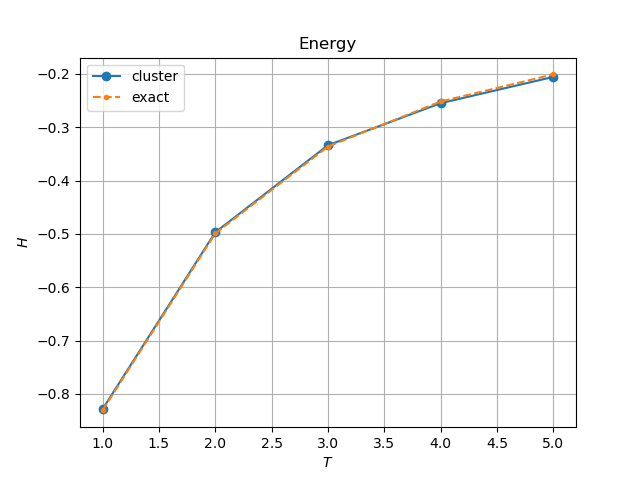

In [17]:
plt.figure()
plt.title('Energy')
plt.xlabel(r'$T$')
plt.ylabel(r'$H$')
plt.plot(T, ene_cluster, '-o', label='cluster')
plt.plot(T, ene_exact, '--.', label='exact')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<IPython.core.display.Javascript object>


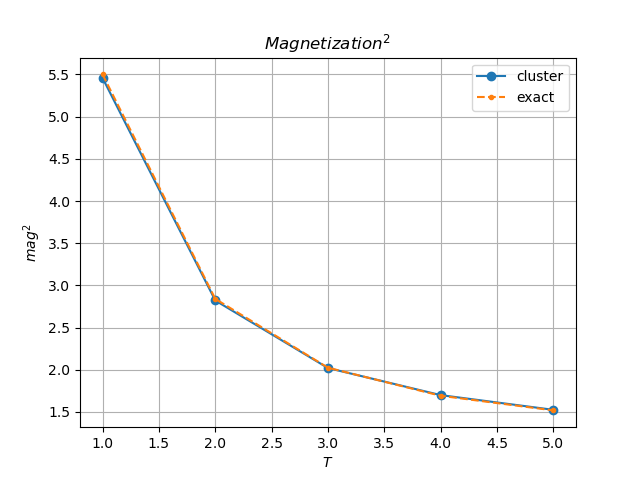

In [19]:
plt.figure()
plt.title(r'$Magnetization^2$')
plt.xlabel(r'$T$')
plt.ylabel(r'$mag^2$')
plt.plot(T, mag_cluster, '-o', label='cluster')
plt.plot(T, mag_exact, '--.', label='exact')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [20]:
ene_cluster

[-0.8286646792763157,
 -0.49712171052631576,
 -0.33377878289473684,
 -0.25501130756578944,
 -0.20572060032894737]

In [21]:
ene_exact

[-0.8310034186903327,
 -0.49923038062541686,
 -0.33625491360157267,
 -0.2517990114881579,
 -0.20106452491640903]